# Final RAG Evaluation


## Load Results


In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style='whitegrid')
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
RESULTS_DIR = PROJECT_ROOT / 'results'
csv_path = RESULTS_DIR / 'experiment_results.csv'
df = pd.read_csv(csv_path)
display(df.head())


,question,time_vanilla,time_reflective,tokens_vanilla,tokens_reflective,grounding_reflective,keyword_precision_vanilla_k,keyword_recall_vanilla_k,semantic_precision_vanilla_k,semantic_recall_vanilla_k,keyword_precision_k,keyword_recall_k,semantic_precision_k,semantic_recall_k
0,Which sport has teams of 6 players: football o...,4962.0350,70798.8027,1,228,0.770642,0.2,0.058824,0.2,1.0,0.2,0.058824,0.2,0.166667
1,At maximal velocity what is the approximate st...,4195.8649,82310.2056,12,145,0.822695,0.4,0.250000,0.0,0.0,0.4,0.250000,0.4,0.666667
2,What tactical innovation is credited to Hungar...,4407.7961,52933.5922,16,43,0.872340,0.2,0.058824,0.0,0.0,0.2,0.058824,0.2,0.500000


## Summary Statistics


In [2]:
analysis_cols = [
    'time_vanilla', 'time_reflective',
    'tokens_vanilla', 'tokens_reflective',
    'grounding_reflective',
    'keyword_precision_vanilla_k', 'keyword_recall_vanilla_k',
    'semantic_precision_vanilla_k', 'semantic_recall_vanilla_k',
    'keyword_precision_k', 'keyword_recall_k',
    'semantic_precision_k', 'semantic_recall_k',
]
df = df.dropna(subset=analysis_cols).copy()
for col in analysis_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['question_label'] = [f'Q{i+1}' for i in range(len(df))]
df['time_ratio'] = np.where(df['time_vanilla'] == 0, np.nan, df['time_reflective'] / df['time_vanilla'])
df['token_ratio'] = np.where(df['tokens_vanilla'] == 0, np.nan, df['tokens_reflective'] / df['tokens_vanilla'])
df['time_delta_ms'] = df['time_reflective'] - df['time_vanilla']
df['token_delta'] = df['tokens_reflective'] - df['tokens_vanilla']

averages = df[analysis_cols].mean().to_frame(name='average').T
ratios = pd.DataFrame({
    'avg_time_ratio': df['time_ratio'].mean(),
    'avg_tokens_ratio': df['token_ratio'].mean(),
    'grounding_avg': df['grounding_reflective'].mean(),
    'keyword_precision_vanilla_avg': df['keyword_precision_vanilla_k'].mean(),
    'keyword_recall_vanilla_avg': df['keyword_recall_vanilla_k'].mean(),
    'semantic_precision_vanilla_avg': df['semantic_precision_vanilla_k'].mean(),
    'semantic_recall_vanilla_avg': df['semantic_recall_vanilla_k'].mean(),
    'keyword_precision_avg': df['keyword_precision_k'].mean(),
    'keyword_recall_avg': df['keyword_recall_k'].mean(),
    'semantic_precision_avg': df['semantic_precision_k'].mean(),
    'semantic_recall_avg': df['semantic_recall_k'].mean(),
}, index=['value'])
display(averages.round(3))
display(ratios.round(3))


,time_vanilla,time_reflective,tokens_vanilla,tokens_reflective,grounding_reflective,keyword_precision_vanilla_k,keyword_recall_vanilla_k,semantic_precision_vanilla_k,semantic_recall_vanilla_k,keyword_precision_k,keyword_recall_k,semantic_precision_k,semantic_recall_k
average,4521.899,68680.867,9.667,138.667,0.822,0.267,0.123,0.067,0.333,0.267,0.123,0.267,0.444


,avg_time_ratio,avg_tokens_ratio,grounding_avg,keyword_precision_vanilla_avg,keyword_recall_vanilla_avg,semantic_precision_vanilla_avg,semantic_recall_vanilla_avg,keyword_precision_avg,keyword_recall_avg,semantic_precision_avg,semantic_recall_avg
value,15.298,80.924,0.822,0.267,0.123,0.067,0.333,0.267,0.123,0.267,0.444


## Comparative Visualizations


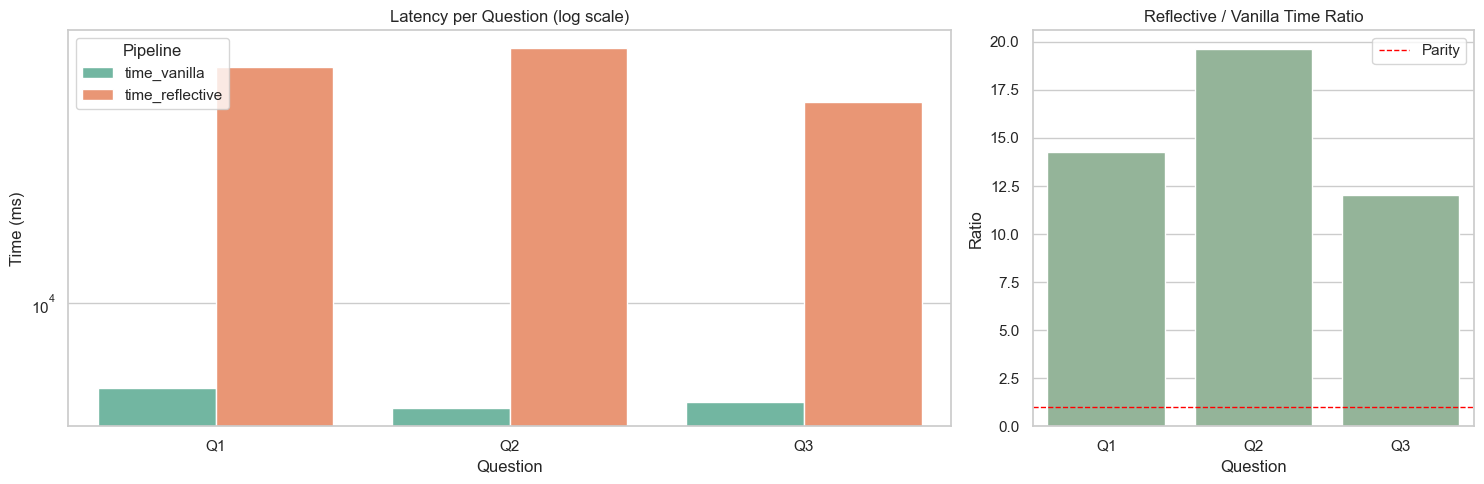

In [3]:
time_long = df[['question_label', 'question', 'time_vanilla', 'time_reflective']].melt(
    id_vars=['question_label', 'question'],
    var_name='pipeline',
    value_name='time_ms',
)
fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [2, 1]})
sns.barplot(data=time_long, x='question_label', y='time_ms', hue='pipeline', palette='Set2', ax=axes[0])
axes[0].set_title('Latency per Question (log scale)')
axes[0].set_xlabel('Question')
axes[0].set_ylabel('Time (ms)')
axes[0].set_yscale('log')
axes[0].legend(title='Pipeline', loc='upper left')
for label in axes[0].get_xticklabels():
    label.set_rotation(0)
sns.barplot(data=df, x='question_label', y='time_ratio', color='#8fb996', ax=axes[1])
axes[1].axhline(1, color='red', linestyle='--', linewidth=1, label='Parity')
axes[1].set_title('Reflective / Vanilla Time Ratio')
axes[1].set_xlabel('Question')
axes[1].set_ylabel('Ratio')
axes[1].legend()
plt.tight_layout()
plt.show()


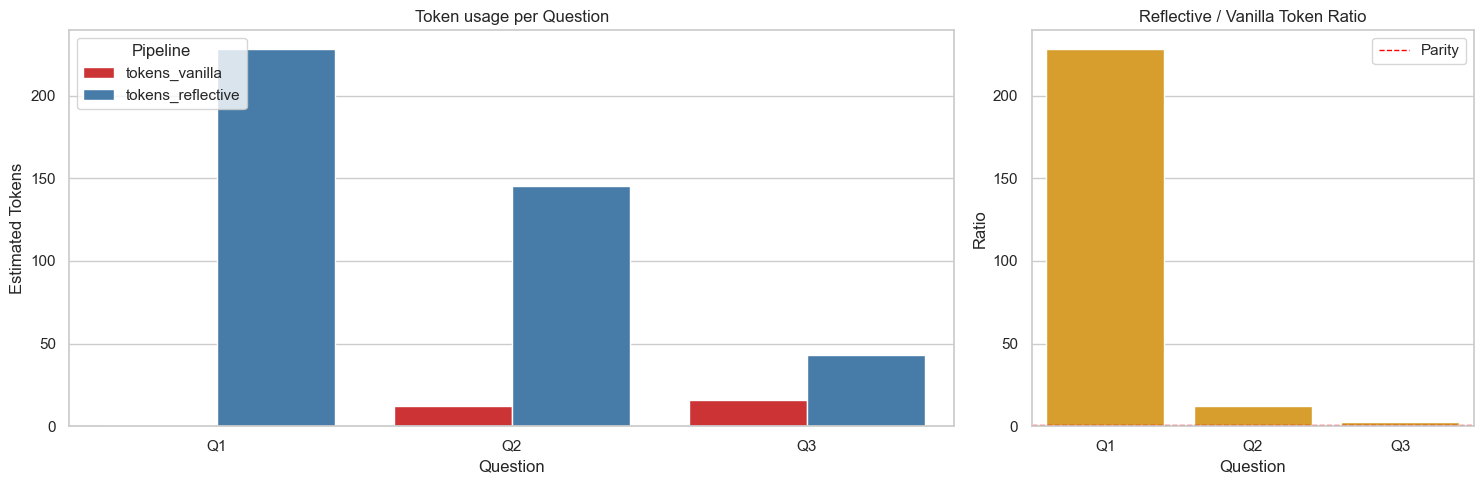

In [8]:
token_long = df[['question_label', 'question', 'tokens_vanilla', 'tokens_reflective']].melt(
    id_vars=['question_label', 'question'],
    var_name='pipeline',
    value_name='tokens',
)
fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [2, 1]})
sns.barplot(data=token_long, x='question_label', y='tokens', hue='pipeline', palette='Set1', ax=axes[0])
axes[0].set_title('Token usage per Question')
axes[0].set_xlabel('Question')
axes[0].set_ylabel('Estimated Tokens')
axes[0].legend(title='Pipeline', loc='upper left')
sns.barplot(data=df, x='question_label', y='token_ratio', color='#f3a712', ax=axes[1])
axes[1].axhline(1, color='red', linestyle='--', linewidth=1, label='Parity')
axes[1].set_title('Reflective / Vanilla Token Ratio')
axes[1].set_xlabel('Question')
axes[1].set_ylabel('Ratio')
axes[1].legend()
plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
scatter = sns.scatterplot(
    data=df,
    x='time_ratio',
    y='grounding_reflective',
    hue='keyword_precision_k',
    size='token_ratio',
    sizes=(80, 400),
    palette='viridis',
    ax=ax,
)
for _, row in df.iterrows():
    ax.text(row['time_ratio'] * 1.02, row['grounding_reflective'] + 0.005, row['question_label'], fontsize=9)
ax.set_title('Grounding vs Latency Trade-off')
ax.set_xlabel('Time Ratio (Reflective / Vanilla)')
ax.set_ylabel('Grounding Score (Reflective)')
ax.axvline(1, color='red', linestyle='--', linewidth=1, alpha=0.7)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Keyword Precision / Token Ratio', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


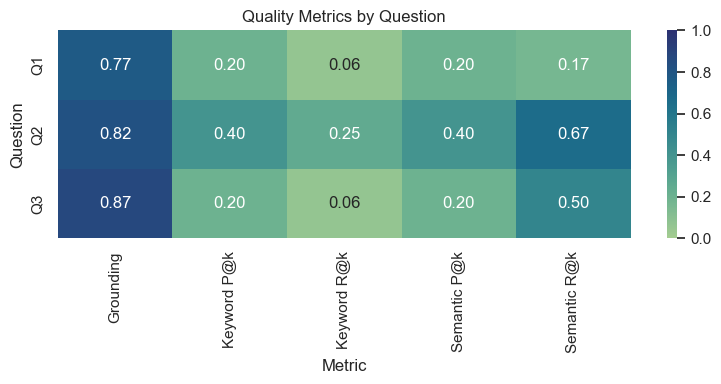

In [6]:
quality_cols = ['grounding_reflective', 'keyword_precision_k', 'keyword_recall_k', 'semantic_precision_k', 'semantic_recall_k']
quality_matrix = df.set_index('question_label')[quality_cols].copy()
quality_matrix.columns = ['Grounding', 'Keyword P@k', 'Keyword R@k', 'Semantic P@k', 'Semantic R@k']
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(quality_matrix, annot=True, fmt='.2f', cmap='crest', vmin=0, vmax=1, ax=ax)
ax.set_title('Quality Metrics by Question')
ax.set_xlabel('Metric')
ax.set_ylabel('Question')
plt.tight_layout()
plt.show()


## Export Metrics


In [7]:
evaluation_metrics_path = RESULTS_DIR / 'evaluation_metrics.csv'
evaluation_summary_path = RESULTS_DIR / 'evaluation_summary.json'
export_cols = ['question_label', 'question'] + analysis_cols + ['time_ratio', 'token_ratio', 'time_delta_ms', 'token_delta']
df[export_cols].to_csv(evaluation_metrics_path, index=False)
summary_payload = {
    'averages': averages.to_dict(orient='records')[0],
    'ratios': ratios.to_dict(orient='records')[0],
    'num_questions': int(len(df)),
}
evaluation_summary_path.write_text(json.dumps(summary_payload, ensure_ascii=False, indent=2), encoding='utf-8')
print('Saved evaluation metrics to', evaluation_metrics_path)
print('Saved evaluation summary to', evaluation_summary_path)


Saved evaluation metrics to C:\Users\tomasz.makowski.2\Desktop\SemesterII\ComputationalIntelligence\Project\agentic-rag-architectures\results\evaluation_metrics.csv
Saved evaluation summary to C:\Users\tomasz.makowski.2\Desktop\SemesterII\ComputationalIntelligence\Project\agentic-rag-architectures\results\evaluation_summary.json
